Episode 0, Avg Reward: 0.39, Avg Steps: 62.0
Episode 1000, Avg Reward: 0.15, Avg Steps: 54.9
Episode 2000, Avg Reward: 0.16, Avg Steps: 55.5
Episode 3000, Avg Reward: 0.22, Avg Steps: 52.7
Episode 4000, Avg Reward: 0.06, Avg Steps: 60.0


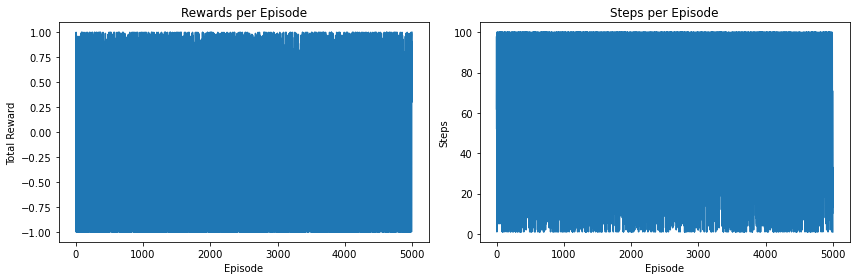

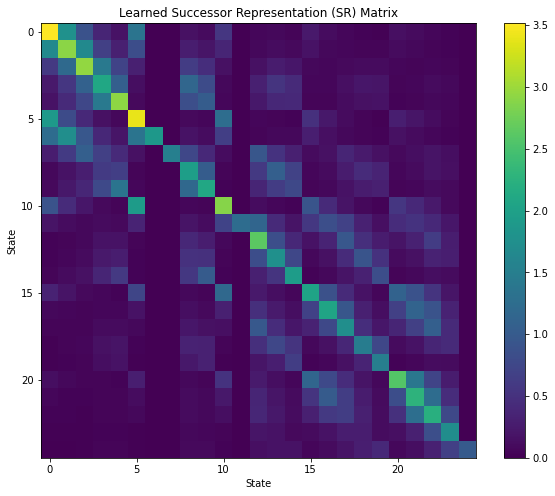

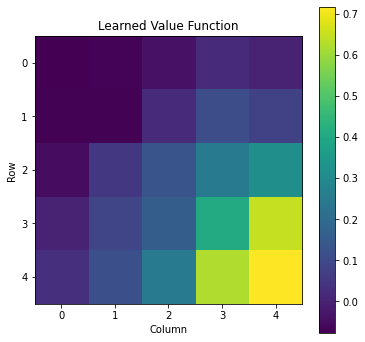

<function matplotlib.pyplot.show(close=None, block=None)>

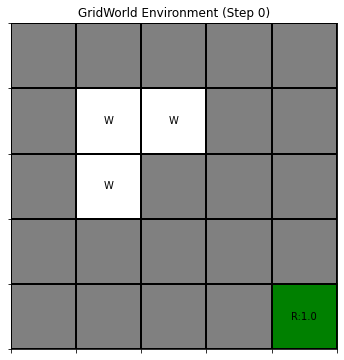

In [35]:
import numpy as np
import matplotlib.pyplot as plt

class GridWorld:
    def __init__(self, width=5, height=5, max_steps=100):
        self.width = width
        self.height = height
        self.state_size = width * height
        self.max_steps = max_steps
        self.steps = 0
        self.reset()
        
        # Define walls and rewards
        self.walls = [(1, 1), (1, 2), (2, 1)]
        self.rewards = {(4, 4): 1.0}  # Goal state with reward
        
    def reset(self):
        # random start position
        self.position = (np.random.randint(0, self.height), np.random.randint(0, self.width))
        self.steps = 0
        return self._get_state()
    
    def _get_state(self):
        return self.position[0] * self.width + self.position[1]
    
    def step(self, action):
        self.steps += 1
        # Actions: 0: up, 1: right, 2: down, 3: left
        moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        new_pos = tuple(map(sum, zip(self.position, moves[action])))
        
        # Check if move is valid
        if (0 <= new_pos[0] < self.height and 
            0 <= new_pos[1] < self.width and 
            new_pos not in self.walls):
            self.position = new_pos
            
        # Get reward and check if done
        reward = self.rewards.get(self.position, 0.0)
        done = reward > 0 
        
        # Add small negative reward for each step to encourage efficiency
        if not reward:
            reward = -0.01
        
        return self._get_state(), reward, done
    
    def render(self, ax=None):
        """Visualize the environment"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
    
        # Create grid
        grid = np.zeros((self.height, self.width))
        
        # Mark walls
        for wall in self.walls:
            grid[wall] = -1
            
        # Mark rewards
        for pos, reward in self.rewards.items():
            grid[pos] = reward
            
        # Create custom colormap
        from matplotlib.colors import ListedColormap
        colors = ['white', 'gray', 'green']  # For empty, walls, reward
        cmap = ListedColormap(colors)
        
        # Plot grid
        ax.imshow(grid, cmap=cmap, vmin=-1, vmax=1)
        
        # Add grid lines
        ax.grid(True, which='major', color='black', linewidth=2)
        
        # Set tick positions and empty labels correctly
        ax.set_xticks(np.arange(-.5, self.width, 1))
        ax.set_yticks(np.arange(-.5, self.height, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        # Add labels
        for i in range(self.height):
            for j in range(self.width):
                if (i, j) in self.walls:
                    ax.text(j, i, 'W', ha='center', va='center')
                elif (i, j) in self.rewards:
                    ax.text(j, i, f'R:{self.rewards[(i,j)]}', ha='center', va='center')
        
        ax.set_title(f'GridWorld Environment (Step {self.steps})')
        return ax
    

class SuccessorRepresentation:
    def __init__(self, state_size, num_actions, gamma=0.9, alpha=0.1):
        self.state_size = state_size
        self.num_actions = num_actions
        self.gamma = gamma  # Discount factor
        self.alpha = alpha  # Learning rate
        
        # Initialize SR matrix and reward weights
        self.psi = np.zeros((state_size, state_size))
        self.w = np.zeros(state_size)  # Reward weights
        
        # Initialize policy (random)
        self.policy = np.ones((state_size, num_actions)) / num_actions
        
    def update(self, state, next_state, reward, done):
        # One-hot state representation
        phi_s = np.zeros(self.state_size)
        phi_s[state] = 1
        
        # Update SR matrix
        target = phi_s + self.gamma * self.psi[next_state] * (1 - done)
        self.psi[state] += self.alpha * (target - self.psi[state])
        
        # Update reward weights
        self.w[state] += self.alpha * (reward - self.w[state])
        
    def get_value(self, state):
        # Compute value function using SR and reward weights
        return np.dot(self.psi[state], self.w)
    
    def choose_action(self, state, epsilon=0.1):
        if np.random.random() < epsilon:
            return np.random.randint(self.num_actions)
        else:
            # Get values for all possible next states
            values = []
            env_copy = GridWorld()
            for action in range(self.num_actions):
                env_copy.position = (state // env_copy.width, state % env_copy.width)
                next_state, _, _ = env_copy.step(action)
                values.append(self.get_value(next_state))
            return np.argmax(values)
        

def train_sr(episodes=1000, max_steps=100): 
    env = GridWorld(max_steps=100)  # Add max_steps parameter
    sr = SuccessorRepresentation(env.state_size, 4)
    
    rewards_history = []  # Track rewards for monitoring learning
    steps_history = []    # Track steps per episode
    
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        max_counter = 0

        while not done and max_counter < max_steps:
            max_counter += 1
            action = sr.choose_action(state, epsilon=1)
            next_state, reward, done = env.step(action)
            
            # Update SR and weights
            sr.update(state, next_state, reward, done)
            state = next_state
            episode_reward += reward
        
        rewards_history.append(episode_reward)
        steps_history.append(env.steps)
            
        if episode % 1000 == 0:
            avg_reward = np.mean(rewards_history[-100:]) if rewards_history else 0
            avg_steps = np.mean(steps_history[-100:]) if steps_history else 0
            print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Avg Steps: {avg_steps:.1f}")
    
    return sr, rewards_history, steps_history

# Example usage:
sr_agent, rewards, steps = train_sr(5000)

# Plot learning curves
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(rewards)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(122)
plt.plot(steps)
plt.title('Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Steps')

plt.tight_layout()
plt.show()

# Visualize the learned SR matrix
plt.figure(figsize=(10, 8))
plt.imshow(sr_agent.psi, cmap='viridis')
plt.colorbar()
plt.title('Learned Successor Representation (SR) Matrix')
plt.xlabel('State')
plt.ylabel('State')
plt.show()

# Visualize the learned value function
values = np.array([sr_agent.get_value(s) for s in range(sr_agent.state_size)])
values = values.reshape(5, 5)
plt.figure(figsize=(6, 6))
plt.imshow(values, cmap='viridis')
plt.colorbar()
plt.title('Learned Value Function')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

# render the environment
env = GridWorld()
env.render()
plt.show